In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import re

In [73]:
house_data = pd.read_csv('house_data.csv',index_col = 0)

In [77]:
house_data.head()

,Antal rum,Avgift/månad,Begärt pris,Boarea,Byggår,Driftskostnad,Förening,Pris per kvadratmeter,Prisutveckling,address,coordinate,id,map_url,price,sale_date,type,url,Biarea,Tomtarea
938778,4.0,5604.0,2475000.0,103.0,2008.0,9600.0,\n Brf Höjdpunkten\n,24757.0,\n\n +75 000 kr (+3 %)\n,Björkhagegatan 6,"[57.92291326887233, 12.502651264129536]",938778.0,https://maps.googleapis.com/maps/api/js?librar...,2550000.0,Såld 2019-01-28,bostadsratt,/salda/bostadsratt-4rum-stadsskogen-alingsas-k...,NaN,NaN
938744,7.0,NaN,1995000.0,175.0,1958.0,52400.0,NaN,13029.0,\n\n +285 000 kr (+14 %)\n,Ekebackevägen 1,"[58.47241420896091, 11.669846459571746]",938744.0,https://maps.googleapis.com/maps/api/js?librar...,2280000.0,Såld 2019-01-28,villa,/salda/villa-7rum-lilla-foss-munkedals-kommun-...,145.0,1483.0
938717,5.0,NaN,3495000.0,103.0,1979.0,38865.0,NaN,32330.0,\n\n -165 000 kr (-5 %)\n,Agnebäcksvägen 24,"[57.69013704556706, 12.208904027993107]",938717.0,https://maps.googleapis.com/maps/api/js?librar...,3330000.0,Såld 2019-01-28,radhus,/salda/radhus-5rum-landvetter-harryda-kommun-a...,NaN,201.0
938962,5.0,NaN,2275000.0,137.0,1980.0,36000.0,NaN,16606.0,\n,Tvåöringsgränd 12,"[58.377188776295206, 11.952471921867492]",938962.0,https://maps.googleapis.com/maps/api/js?librar...,2275000.0,Såld 2019-01-28,villa,/salda/villa-5rum-helenedal-uddevalla-kommun-t...,21.0,346.0
938923,3.0,4492.0,2650000.0,70.0,2016.0,NaN,\n BRF Lergöken\n,40000.0,\n\n +150 000 kr (+6 %)\n,Lergöksgatan 15,"[57.65738875448929, 11.9003493296695]",938923.0,https://maps.googleapis.com/maps/api/js?librar...,2800000.0,Såld 2019-01-28,bostadsratt,/salda/bostadsratt-3rum-frolunda-goteborgs-kom...,NaN,NaN


In [75]:
regexp = re.compile('(\d+)')

def find_numbers(text):

    if pd.isnull(text):
        return text
    
    try:
        text_ = re.sub('m2','',text)
    except:
        return text
    
    try:
        results = regexp.findall(text_)
    except:
        return text_
    
    price_str = ''
    for result in results:
        price_str+=result
    
    try:
        price = float(price_str)
    except:
        price = None
    
    return price

In [101]:
date_regexp = re.compile('(\d\d\d\d-\d\d-\d\d)')
def find_date(date_string):
    result = date_regexp.search(date_string)
    return result.group(1)



In [109]:
house_data['sale_date'] = pd.to_datetime(house_data['sale_date'].apply(func = find_date))



In [110]:
col_names = ['Antal rum','Avgift/månad','Begärt pris','Boarea','Byggår','Driftskostnad','Pris per kvadratmeter','price','Tomtarea','Biarea']

for col_name in col_names:
    house_data[col_name] = house_data[col_name].apply(find_numbers)

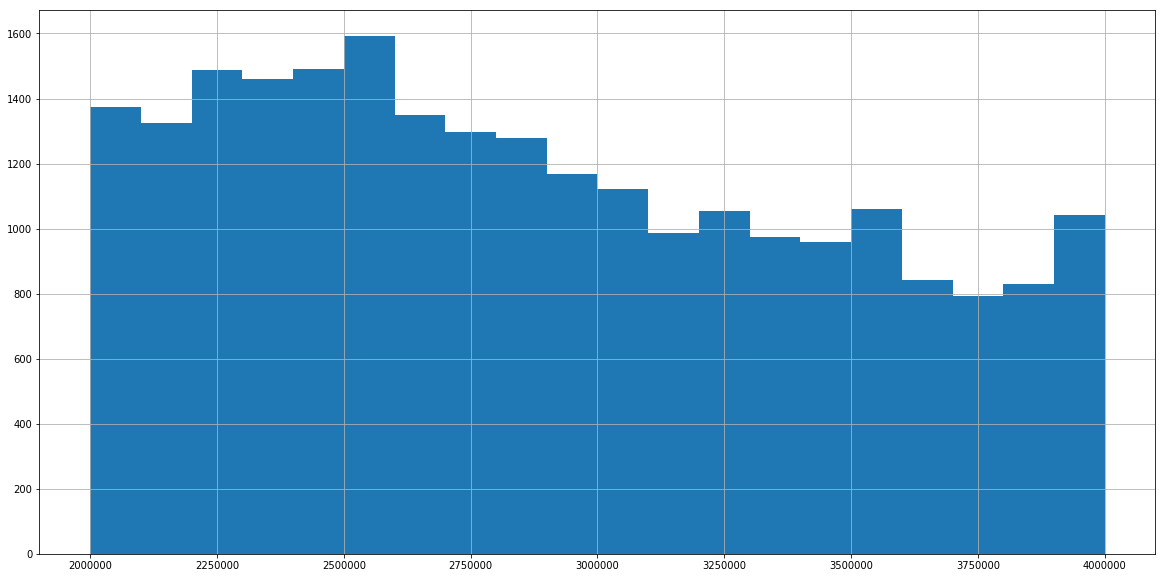

In [111]:
fig,ax = plt.subplots()
house_data['price'].hist(bins = 20,ax = ax)

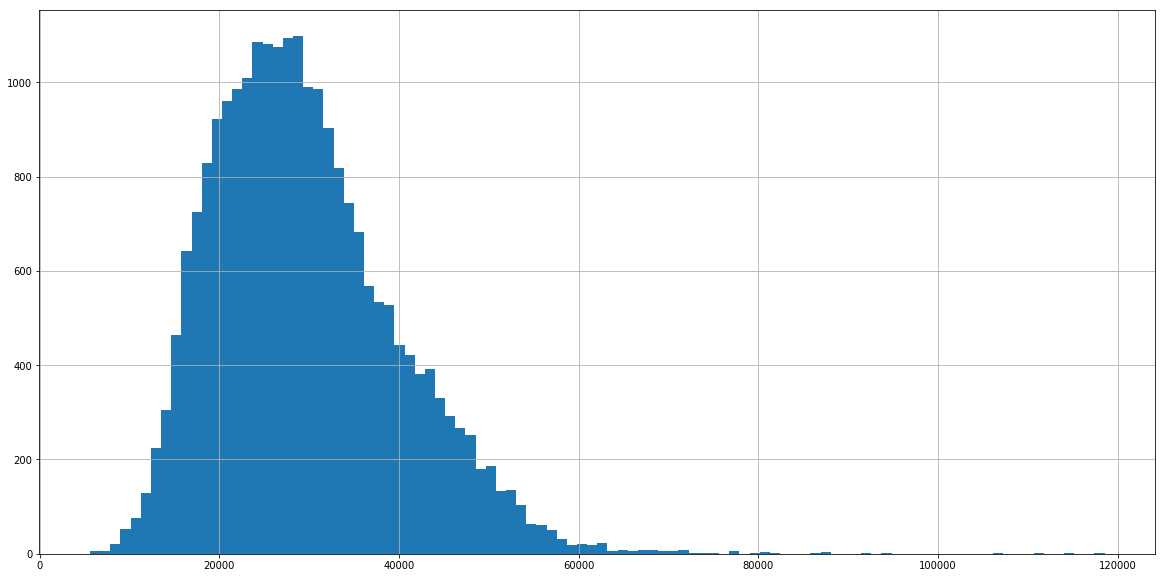

In [112]:
fig,ax = plt.subplots()
house_data['Pris per kvadratmeter'].hist(bins = 100,ax = ax)

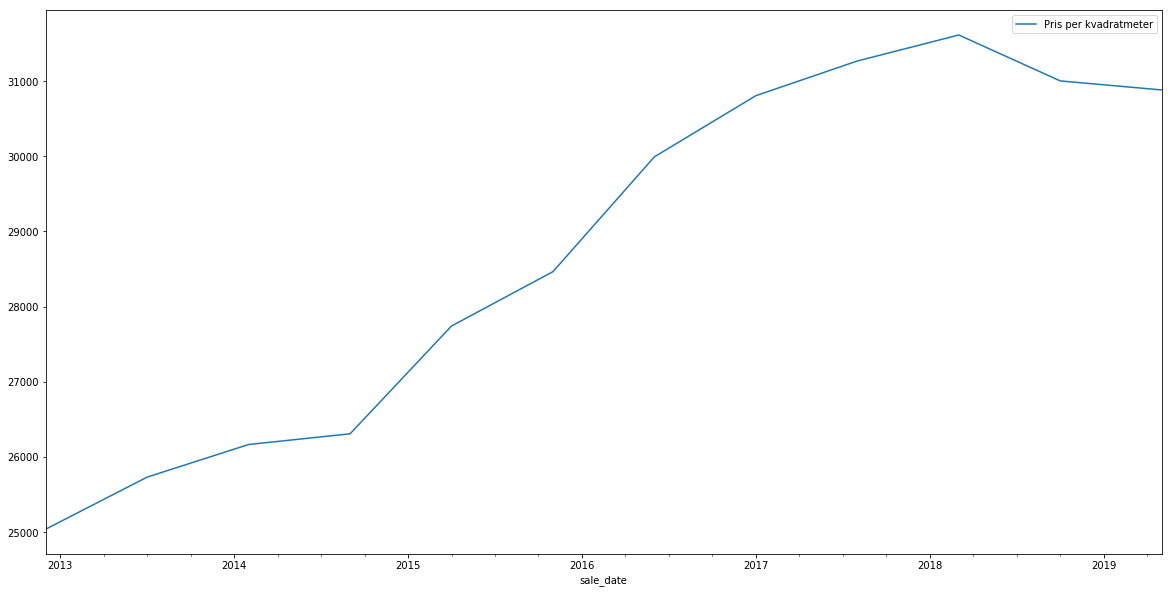

In [141]:
fig,ax = plt.subplots()
mask = house_data['Pris per kvadratmeter'] < 70000
house_data_ = house_data.loc[mask].copy()
house_data_ = house_data_.set_index('sale_date')

house_data_.resample('7M').mean().plot(y = 'Pris per kvadratmeter',ax = ax,alpha=1)